# Audio MNIST Classifier

<a href="https://colab.research.google.com/github/inspektral/audioMNIST-classifier/blob/main/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This report its an overview of the repository and it goes over the details of data processing, architecture, training evaluation and prediction of a classifier for the audio MNIST dataset.

The Dataset contains 30,000 samples of spoken digits, 60 speakers, 0 to 9.

The classifier is a small 3 blocks CNN that predicts the digit starting from the MFCCs of the audio file.


In [1]:
import os

if 'google.colab' in str(get_ipython()):
    repo_name = 'audioMNIST-classifier'
    repo_path = f'/content/{repo_name}'
    
    if os.getcwd() != repo_path:
        if not os.path.exists(repo_path):
            !git clone https://github.com/inspektral/audioMNIST-classifier.git
        os.chdir(repo_path)
        !pip install -r requirements.txt
        !git clone https://github.com/soerenab/AudioMNIST.git data/AudioMNIST

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio

## Predictions

To run the prediction script it is sufficient to run the predict.py script, the configuration for the prediction is in the config file. The preditions will run on all the data in the DATA_PATH folder and safe a pandas dataframe in the a .csv in the RESULTS_PATH file.

In the predict_data folder there are already some files that can be used for predictions. Mind that the files are trimmed at 1s, so everything after the 1s mark will be discarded and not seen by the model.

In [3]:
!python predict.py

Starting prediction...
  0%|                                                    | 0/20 [00:00<?, ?it/s]/home/tito/miniconda3/envs/cuda-pytorch/lib/python3.10/site-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 10.18it/s]
Predictions saved to predictions.csv


In [10]:
predictions_df = pd.read_csv('predictions.csv')
predictions_df.head()

,filepath,predicted_label
0,predict_data/giulio/giulio_05.wav,5
1,predict_data/giulio/giulio_06.wav,8
2,predict_data/giulio/giulio_04.wav,4
3,predict_data/giulio/giulio_09.wav,9
4,predict_data/giulio/giulio_08.wav,8


In [5]:
Audio(predictions_df.iloc[0]['filepath'], rate=48000)

## Data

### Dataset

The AudioMNIST dataset is an open-source collection of 30,000 audio recordings of English spoken digits (0-9).

### Processing

The processing applied on the data is:
- Normalization: the audio waveform is normalized in the range (-1, 1), in this way the model won't be sensitive to differences in amplitude. This step is done automatically by torchaudio when loading the waveform.
- Resampling: the waveform is resampled from 48KHz to 16KHz this is done to reduce drastically reduce the amount of data while keeping all the necessary information, in particular the higher frequencies above 8KHz are lost, but those are not key in distinguishing different phonemes so this lossy compression step shouldn't impact the model.
- Trimming and padding: since constant dimensions are needed for the input layer of the model audio files are resized to 1s by trimming or padding the and, whichever is needed
- MFCC: Mel Frequency Cepstral Coefficients are extracted via torchaudio (which has a librosa inspired API but works directly on tensors), just the first 20 coefficients are kept, those should be enough to give an idea of the spectrum shape for ervery fft frame and that should be good enough to be learned as a phoneme and then a number. This greatly compresses the data, ending up with just 82 frames and 20 MFCCs, thus a 82x20 table, 1640 values from the starting 48000, a 30x reduction that allows for a much smaller model.

### Loading

The data is loaded with an ad hoc pytorch dataset class (see mfccdataset.py) and pytorch dataloaders(see utils)

## Architecture

The architecture is a tiny and very standard CNN with three blocks, the input layer is 1 channel and starting from 4 the channels double every block. For the classification task a fully coneccted layer is added at the end. Kernel size 3 for the convolution and 2 for the Maxpool are quite standard.

Several model overall sizes have been tried without relevant differences, this is the smallest of the tried ones that reaches acceptable performances

## Training

For the training the datset is split, 80% of the data is used for the training 20% for the testing. It is important to note that the dataset is split based on the speakers, so 48 speakers are used for training and 12 for testing. This is done to have a better evaluation, since it ensures that the model is not trained on the speakers on which it is tested. Another important issue to address is that the dataset is all recorded with the same audio setup, which is of semi-professional level, predictions on audio recorded with different setups, especially of a much lesser quality like phones or laptop microphones, might be much less accurate.

Training is done with a cross entropy loss function, since this is a calssification task.
Batch size is set to 32, and the number of epochs is 5, after that the model seems to plateau, learning rate is 0.001.

On the CPU (i7-12650H), training lasts around 15 minutes, if the logs are turned of (TRAINING_LOGS = False in config.py) if those are turned on the model is evaluated on the whole dataset, both training and test every epoch and that almost doubles the training time.

To train the model it is sufficient to run the train.py script

In [6]:
# !python train.py

## Evaluation

A good starting point for the evaluation are the training logs, those provide accuracy and loss on both the training and the test set for every epoch. From the table and the plots it is possible to see that the training is working and the final accuracy on the test set is 98.6%.

A pyhthon evaluate.py script is provided, this script runs the model on the test set and provides the accuracy and average loss.

In [7]:
training_log_df = pd.read_csv('training_log.csv')
training_log_df

,epoch,train_accuracy,train_loss,test_accuracy,test_loss
0,0,10.000000,17.910402,10.000000,18.632457
1,1,98.091667,0.073377,96.266667,0.130486
2,2,99.216667,0.030399,97.816667,0.082298
3,3,99.575000,0.018038,98.383333,0.054115
4,4,99.716667,0.013017,98.033333,0.067433
5,5,99.533333,0.015522,98.600000,0.047307


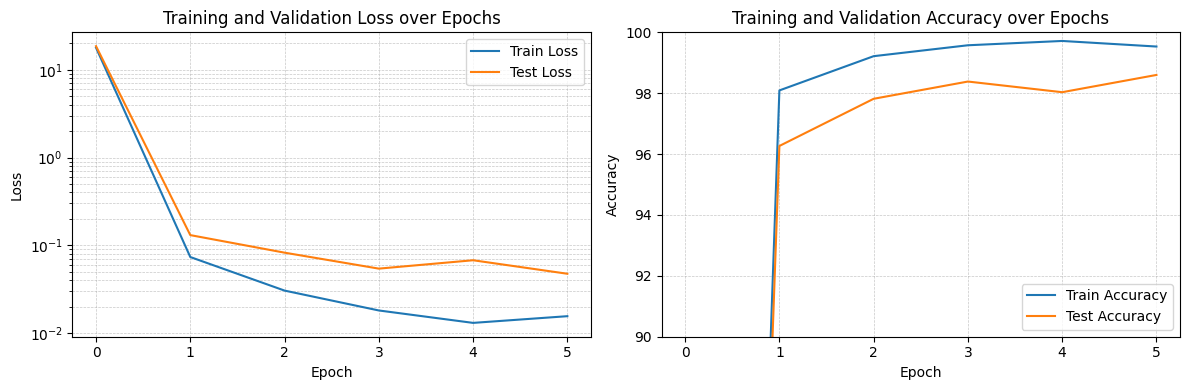

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(training_log_df['epoch'], training_log_df['train_loss'], label='Train Loss')
ax.plot(training_log_df['epoch'], training_log_df['test_loss'], label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss over Epochs')
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend()

ax = axes[1]
ax.plot(training_log_df['epoch'], training_log_df['train_accuracy'], label='Train Accuracy')
ax.plot(training_log_df['epoch'], training_log_df['test_accuracy'], label='Test Accuracy')
ax.set_ylim(90, 100)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy over Epochs')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

More in depth evaluations can be done with the prediction results, for that it would be interesting to have a dataset with various cases and with setups different from the ones of audio-MNIST. For this a very small selection has been crafted, two voices, one male italian accent (giulio), one female german accent (sheila) have been recorded with a simple phone, the spoken nomber is the number at the file name.

It can be seen that for both speaker 6 is missclassified as 8, which is quite interesting since the consonants of the two are very different. A common thing between the two is the length, both are very short and the vowel is not very different.
More data would be needed to understand those kind of issues, but I think it is not due to the model architecture or the training process but more an issue of the training data, which is all recorded with good quality tools in a very controlled environment.

In [9]:
predictions_df

,filepath,predicted_label
0,predict_data/giulio/giulio_05.wav,5
1,predict_data/giulio/giulio_06.wav,8
2,predict_data/giulio/giulio_04.wav,4
3,predict_data/giulio/giulio_09.wav,9
4,predict_data/giulio/giulio_08.wav,8
5,predict_data/giulio/giulio_03.wav,3
6,predict_data/giulio/giulio_07.wav,7
7,predict_data/giulio/giulio_02.wav,2
8,predict_data/giulio/giulio_00.wav,0
9,predict_data/giulio/giulio_01.wav,1


## Further work and improvements

The following are various ideas that could be implemented to get better results:
- More thorough evaluation: both the test set with confusion matrix etc but especially on a ad hoc assembled (or publicly available) benchmark dataset
- Data augmentation: training data could be augmented with repitching, background noise, saturation, filtering, in order to have a more robust system, of course this implies longer training
- Audio preprocessing: to better highlight the phonemes and help the system an audio pipeline could be implemented in order to highlight consonants and difference in the vowels, this would likely comprice filtering and multiband compression. I believe that this would be the most important single thing to achieve better performance.
- Mel spectrogram: instead of MFCCs mel spectrogram could be used directly, this is a common approach that could lead to better results but increasing the size of the input by around an order of magnitude.
- Tweaks in the stft stage: stft has few parameters (window size, window type, hop size) that could be tweked and optimized to achieve the best frequency-time resolution tradeoff.
- tweaks in the architecture: although different hyperparameters have been tested changing some parts of the architecture like adding layers, adding dropout or other tweaks could lead to slightly better results.
- add recurrence: a crnn could be used to take care of the sequentiality of data, this type of architecture is more complex, long to train and maybe overkill but would probably lead to an improvement in accuracy.   